# ISLP - Chapter 12 - Exercise 12
### Author: pzuehlke

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

The solution is practically identical to that of the first part of Exercise
$ 11 $. The only difference is that instead of manually constructing the
approximation from the $ \mathbf{U} $, $ \mathbf{\Sigma} $, and $ \mathbf{V} $
matrices, we will:

1. Fit a PCA model with `n_components=M`.
2. Use `transform()` to get the principal component scores.
3. Use `inverse_transform()` to reconstruct the approximation.

Recall from the solution to Exercise $ 11 $ that if $ \mathbf{X} $
is our data matrix and we compute SVD as
$$
    \mathbf{X} = \mathbf{U} \mathbf{\Sigma} \mathbf{V}^T\,,
$$
then, a minimizing rank-$ M $ approximation using would be
$$
  \widetilde{\mathbf{X}}_M = \mathbf{U}_M\mathbf{\Sigma}_M\mathbf{V}_M^T
$$
With PCA, we're doing the same thing behind the scenes, using a different interface:
* `X_pca = pca.fit_transform(X_hat)` yields the principal component scores (equivalent
  to $ \mathbf{U}_M\mathbf{\Sigma}_M $).
* `pca.inverse_transform(X_pca)` reconstructs the approximation (multiplies by $ \mathbf{V}^T_M $).

In [2]:
def matrix_completion_pca(X, M=1, max_iter=100, threshold=1e-7, verbose=False):
    """
    Perform matrix completion using Algorithm 12.1 and PCA.
    
    Parameters:
    -----------
    X : numpy array
        The data matrix with missing values (np.nan).
    M : int
        Number of components to use in the low-rank approximation.
    max_iter : int
        Maximum number of iterations.
    threshold : float
        Convergence threshold for _relative_ error.
    verbose : bool
        Whether to print progress in each iteration.
    
    Returns:
    X_hat : numpy array
        The completed matrix.
    iterations : int
        Number of iterations performed.
    rel_errors : list
        Relative errors at each iteration.
    """
    # Step 1: Initialize X_hat by replacing missing values with column means:
    is_missing = np.isnan(X)
    X_hat = X.copy()  # will hold the final result
    X_bar = np.nanmean(X_hat, axis=0)
    # Replace missing values with column means:
    for j in range(X.shape[1]):
        X_hat[is_missing[:, j], j] = X_bar[j]
    # Setup for tracking progress:
    rel_err = 1
    count = 0
    rel_errors = []
    # Compute initial MSE of non-missing elements:
    mse_0 = np.mean(X[~is_missing]**2)
    mse_old = mse_0
    
    # Step 2: Perform iterative algorithm:
    while rel_err > threshold and count < max_iter:
        count += 1
        
        # Step 2(a): Low-rank approximation of X_hat using PCA.
        # CHANGE: Replace SVD with PCA:
        pca = PCA(n_components=M)
        X_pca = pca.fit_transform(X_hat)
        X_approx = pca.inverse_transform(X_pca)
        
        # Step 2(b): Update X_hat using X_approx only for missing entries:
        X_hat[is_missing] = X_approx[is_missing]
        
        # Step 2(c): Compute new relative error:
        mse = np.mean(((X - X_approx)[~is_missing])**2)
        rel_err = (mse_old - mse) / mse_0
        mse_old = mse
        rel_errors.append(rel_err)
        
        if verbose:
            print(f"Iteration: {count}, MSE: {mse:.3f}, relative error: {rel_err:.2e}")
    
    return X_hat, count, rel_errors

Now let's check that our function is correct by doing the same work as in the
previous exercise, from which the following code was copied and pasted (taking
care to change the calls to `matrix_completion` to `matrix_completion_pca`):

In [7]:
def run_experiment(X, missing_percentages, M_values, repetitions=10):
    """
    Run matrix completion experiments with varying percentages of missing values
    and different M values.
    
    Parameters:
    -----------
    X : numpy array
        The data matrix.
    missing_percentages : list
        Percentages of missing values.
    M_values : list
        Values of M to try.
    repetitions : int
        Number of repetitions for each experiment.
    
    Returns:
    --------
    results : numpy array
        Average approximation errors.
    """
    rng = np.random.RandomState(1)
    n, p = X.shape
    results = np.zeros((len(missing_percentages), len(M_values)))
    
    for rep in range(repetitions):
        # Generate all potentially missing indices for this repetition series 
        # at once. As the percentage increases, the missing observations will
        # be subsets of this maximal set:
        max_missing = int(n * p * missing_percentages[-1])
        all_possible_missing_indices = rng.choice(
            n * p, max_missing, replace=False
        )
        
        for i, missing_pct in enumerate(missing_percentages):
            # Take appropriate subset of indices for current percentage:
            n_missing = int(n * p * missing_pct)
            current_missing_indices = all_possible_missing_indices[:n_missing]
            # Convert to row, col format:
            row_idx, col_idx = np.unravel_index(current_missing_indices, (n, p))
            
            for j, M in enumerate(M_values):
                # Create copy and set missing values:
                X_missing = X.copy()
                X_missing[row_idx, col_idx] = np.nan
                
                X_completed, _, _ = matrix_completion_pca(X_missing, M=M)
                
                error = np.mean(((X - X_completed)[row_idx, col_idx])**2)
            
                results[i, j] += error / repetitions
    
    return results

Let's run the experiment on the Boston dataset for $ M = 1,\,2, \cdots, 8 $
and missing percentages $ 5\%,\,10\%, \cdots, 30\% $. This cell takes about $ 10\,s $
to run on my machine (twice the time as in Exercise $ 11 $).

In [8]:
boston = pd.read_csv("Boston.csv")

scaler = StandardScaler()
boston_scaled = scaler.fit_transform(boston)

# Run experiment:
missing_percentages = np.arange(0.05, 0.35, 0.05)
M_values = range(1, 9)
results = run_experiment(boston_scaled, missing_percentages, M_values)

Now let's plot the results of the experiment:

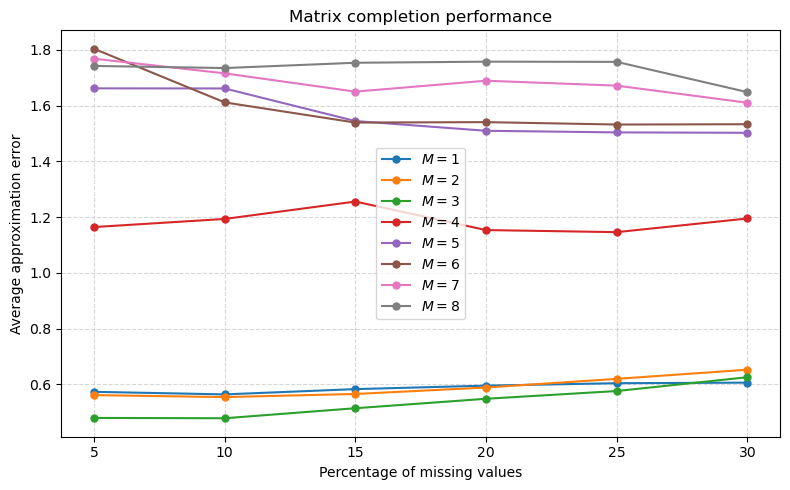

In [9]:
fig, ax = plt.subplots(figsize=(8, 5))
for j, M in enumerate(M_values):
    ax.plot(missing_percentages * 100, results[:, j],
            'o-', label=f"$ M = {M} $", ms=5)
ax.set_xlabel("Percentage of missing values")
ax.set_ylabel("Average approximation error")
ax.set_title("Matrix completion performance")
ax.legend()
ax.grid(True, linestyle='--', alpha=0.5)

fig.tight_layout()
plt.show()

The results are identical to those obtained in the solution to Exercise $ 11 $,
even though we used different packages (NumPy and scikit-learn) in each case.
This is reassuring.